# Reproduction experiment of "Verifying Properties of Binarized Deep Neural Networks"

## Preparation

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   8977      0 --:--:-- --:--:-- --:--:--  8977
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [0]:
import functools
import operator
import chainer
from chainer import Chain, ChainList, functions as F, Link, links as L
from chainer.training import extensions
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import List
%matplotlib inline

In [3]:
chainer.print_runtime_info()

Platform: Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.16.2
CuPy:
  CuPy Version          : 5.2.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2307
iDeep: 2.0.0.post3


In [4]:
!wget "https://www.dropbox.com/sh/ysoxtpfeg4f6kjy/AAA8C9CNDIA7xWfanonfwtpba/mnist_all_rotation_normalized_float_test.npz?dl=1" -O mnist_all_rotation_normalized_float_test.npz
!wget "https://www.dropbox.com/sh/ysoxtpfeg4f6kjy/AADp-gQGvJ19rmHFsX2nSq6Va/mnist_all_rotation_normalized_float_train_valid.npz?dl=1" -O mnist_all_rotation_normalized_float_train_valid.npz
!wget "https://www.dropbox.com/sh/ysoxtpfeg4f6kjy/AABwbnFT9EdPwVgFXQsVyeHVa/mnist_background_images_test.npz?dl=1" -O mnist_background_images_test.npz
!wget "https://www.dropbox.com/sh/ysoxtpfeg4f6kjy/AADy5HIwdFSZ_oDj5eVArApJa/mnist_background_images_train.npz?dl=1" -O mnist_background_images_train.npz

--2019-04-19 15:55:41--  https://www.dropbox.com/sh/ysoxtpfeg4f6kjy/AAA8C9CNDIA7xWfanonfwtpba/mnist_all_rotation_normalized_float_test.npz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/ysoxtpfeg4f6kjy/AAA8C9CNDIA7xWfanonfwtpba/mnist_all_rotation_normalized_float_test.npz [following]
--2019-04-19 15:55:41--  https://www.dropbox.com/sh/dl/ysoxtpfeg4f6kjy/AAA8C9CNDIA7xWfanonfwtpba/mnist_all_rotation_normalized_float_test.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2ccd5bd37837bfc357849eae9b.dl.dropboxusercontent.com/cd/0/get/AfUFQxLrw3uMzO4JkFyDioeyz3nVH7NLBRcRHh2UsRYC4_0-V1pPZTYuboiEwCMUWdYHRDf6fKYhaUYurhhJe1XRvB46baW0dzImJ8G-fM5h-vgst6c2nEePG9fv-UXYKjg/file?dl=1# [following]
--2019-04-19 15:55:41--  https:/

## Model definition

In [0]:
def hard_tanh(x):
    return F.clip(x, -1.0, 1.0)

def hard_sigmoid(x):
    return F.clip((x + 1) / 2, 0.0, 1.0)

def bin(x, stochastic=False):
    if stochastic:
        p = hard_sigmoid(x)
        y_hard = chainer.distributions.Bernoulli(p).sample().data * 2 - 1
        y_hard = chainer.Variable(y_hard.astype(np.float32))
    else:
        y_hard = F.sign(x)

    if chainer.config.train:
        y_soft = hard_tanh(x)
        return (y_hard - y_soft.data) + y_soft
    else:
        return y_hard

In [0]:
class BinLinear(Link):
    def __init__(self, in_size, out_size=None, nobias=False,
                 initialW=None, initial_bias=None):
        super().__init__()

        if out_size is None:
            in_size, out_size = None, in_size
        self.out_size = out_size

        with self.init_scope():
            W_initializer = chainer.initializers._get_initializer(initialW)
            self.W = chainer.Parameter(W_initializer)
            if in_size is not None:
                self._initialize_params(in_size)

            if nobias:
                self.b = None
            else:
                if initial_bias is None:
                    initial_bias = 0
                bias_initializer = chainer.initializers._get_initializer(initial_bias)
                self.b = chainer.Parameter(bias_initializer, out_size)

    def _initialize_params(self, in_size):
        self.W.initialize((self.out_size, in_size))

    def forward(self, x, n_batch_axes=1):
        if self.W.array is None:
            in_size = functools.reduce(operator.mul, x.shape[1:], 1)
            self._initialize_params(in_size)
        W = bin(self.W)
        return F.linear(x, W, self.b, n_batch_axes=n_batch_axes)
      
    def clip_weights(self):
        with chainer.cuda.get_device(self.W.data):
            xp = chainer.cuda.get_array_module(self.W.data)
            self.W.data = xp.clip(self.W.data, -1.0, 1.0)
            
    def binarize_weights(self):
        with chainer.cuda.get_device(self.W.data):
            xp = chainer.cuda.get_array_module(self.W.data)
            self.W.data = xp.sign(self.W.data) 

In [0]:
class Block(Chain):
    def __init__(self, n_output: int, stochastic_activation: bool = False) -> None:
        super().__init__()
        self.stochastic_activation = stochastic_activation
        with self.init_scope():
            self.lin = BinLinear(None, n_output)
            self.bn = L.BatchNormalization(n_output)
            #self.alpha = chainer.Parameter(chainer.initializers._get_initializer(None), (1,n_output))
            #self.gamma = chainer.Parameter(chainer.initializers._get_initializer(0), (1,n_output))

    def __call__(self, x):
      #return bin(self.alpha * self.bn(self.lin(x)) + self.gamma,
       #          self.stochastic_activation and chainer.config.train)
      return bin(self.bn(self.lin(x)), self.stochastic_activation and chainer.config.train)


    def clip_weights(self):
        self.lin.clip_weights()

    def binarize_weights(self):
        self.lin.binarize_weights()


class BNN(Chain):
    def __init__(self, neurons: List[int], stochastic_activation=False) -> None:
        super().__init__()
        with self.init_scope():
          self.input_bn = L.BatchNormalization(neurons[0])
          self.blocks = ChainList(*[Block(n, stochastic_activation=stochastic_activation) for n in neurons[1:-1]])
          self.output_lin = BinLinear(None, neurons[-1])

    def __call__(self, x):
        h = bin(self.input_bn(x))
        for block in self.blocks:
          h = block(h)
        return self.output_lin(h)

    def clip_weights(self):
        for block in self.blocks:
            block.clip_weights()

    def binarize_weights(self):
        for block in self.blocks:
            block.binarize_weights()

In [0]:
class WeightClipping(object):
    name = 'WeightClipping'

    def __call__(self, opt):
        opt.target.predictor.clip_weights()

## Training

In [0]:
def train_model(model, name, train, test, max_epoch = 50, gpu_id = -1, batch_size = 128):
  dir = Path(f'{name}_result')
  
  loss_model = L.Classifier(model)
  train_iter = chainer.iterators.SerialIterator(train, batch_size)
  test_iter = chainer.iterators.SerialIterator(test, batch_size, False, False)
  
  if gpu_id >= 0:
    chainer.cuda.get_device_from_id(gpu_id).use()
    loss_model.to_gpu(gpu_id)
  
  # selection of your optimizing method
  optimizer = chainer.optimizers.Adam()
  
  # Give the optimizer a reference to the model
  optimizer.setup(loss_model)
  optimizer.add_hook(WeightClipping(), timing='post')
  
  # Get an updater that uses the Iterator and Optimizer
  updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu_id)
  
  # Setup a Trainer
  trainer = chainer.training.Trainer(updater, (max_epoch, 'epoch'), out=dir)
  trainer.extend(extensions.LogReport())
  trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
  trainer.extend(extensions.snapshot_object(loss_model.predictor, filename='model_epoch-{.updater.epoch}'))
  trainer.extend(extensions.Evaluator(test_iter, loss_model, device=gpu_id))
  trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
  trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
  trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
  trainer.extend(extensions.dump_graph('main/loss'))
  
  trainer.run()
  
  model.binarize_weights()
  chainer.serializers.save_npz(name + ".npz", model)

### MNIST

In [10]:
train, test = chainer.datasets.mnist.get_mnist()
model_mnist = BNN([28 * 28, 200, 100, 100, 100, 10], stochastic_activation=True)
train_model(model_mnist, "mnist", train, test, max_epoch=50, gpu_id=0, batch_size=128)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           3.72268     0.655617       1.97977               0.8661                    12.01         
2           2.47962     0.767507       1.56089               0.90358                   22.3457       
3           2.13767     0.801756       1.73446               0.912184                  32.3047       
4           1.97309     0.823568       1.45012               0.925138                  42.3208       
5           1.81977     0.838619       1.47524               0.925435                  52.2374       
6           1.68325     0.854328       1.34135               0.93305                   62.3311       
7           1.57046     0.863606       1.35164               0.933742                  72.319        
8           1.45975     0.872963       1.40708               0.934434                  82.3232       
9           1.40253     0.879731       1.27058               0.938687               

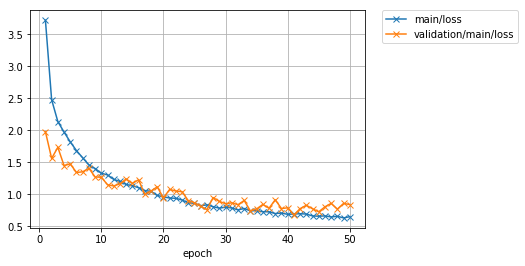

In [11]:
Image('mnist_result/loss.png')

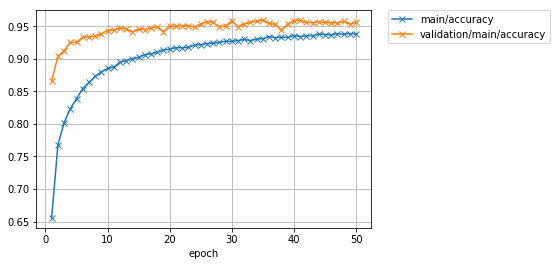

In [12]:
Image('mnist_result/accuracy.png')

In [0]:
from google.colab import files
files.download('mnist.npz')

### MNIST-rot

In [0]:
npz = np.load("mnist_all_rotation_normalized_float_train_valid.npz")
train = chainer.datasets.TupleDataset(npz["x"], npz["y"])
npz = np.load("mnist_all_rotation_normalized_float_test.npz")
test = chainer.datasets.TupleDataset(npz["x"], npz["y"])

In [15]:
model_mnist_rot = BNN([28 * 28, 200, 100, 100, 100, 10], stochastic_activation=True)
train_model(model_mnist_rot, "mnist_rot", train, test, max_epoch=100, gpu_id=0, batch_size=128)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           10.4319     0.226064       8.02822               0.319573                  3.50286       
2           8.78107     0.283078       8.38138               0.282645                  7.48961       
3           8.06413     0.297124       8.66077               0.337448                  11.5339       
4           7.55566     0.311576       6.24291               0.365521                  15.5619       
5           7.12501     0.314993       7.45307               0.335638                  19.6294       
6           6.75076     0.317487       7.22723               0.330015                  23.6816       
7           7.11016     0.321061       7.42477               0.322806                  27.9976       
8           6.8662      0.326277       9.9736                0.3415                    32.0186       
9           6.84718     0.331034       6.47466               0.394669               

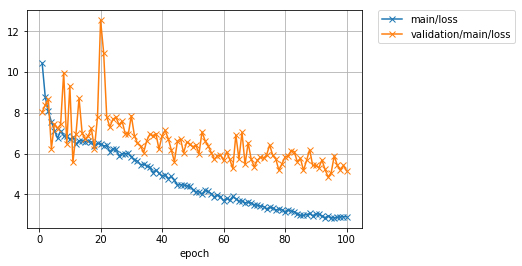

In [16]:
Image('mnist_rot_result/loss.png')

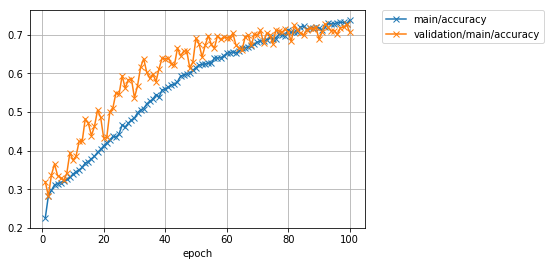

In [17]:
Image('mnist_rot_result/accuracy.png')

In [0]:
from google.colab import files
files.download('mnist_rot.npz')

### MNIST-back-image

In [0]:
npz = np.load("mnist_background_images_train.npz")
train = chainer.datasets.TupleDataset(npz["x"], npz["y"])
npz = np.load("mnist_background_images_test.npz")
test = chainer.datasets.TupleDataset(npz["x"], npz["y"])

In [20]:
model_mnist_back_image = BNN([28 * 28, 200, 100, 100, 100, 10], stochastic_activation=True)
train_model(model_mnist_back_image, "mnist_back_image", train, test, max_epoch=100, gpu_id=0, batch_size=128)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           11.0254     0.189162       7.45792               0.374544                  3.8167        
2           8.68402     0.286154       6.98004               0.415897                  8.11421       
3           7.88626     0.330701       7.10547               0.450228                  12.5078       
4           7.34625     0.351478       6.22561               0.490977                  16.9571       
5           7.06601     0.364279       6.51458               0.511873                  21.4089       
6           6.45822     0.384392       6.13549               0.53336                   25.8285       
7           6.6289      0.385638       5.93749               0.526339                  29.9731       
8           6.50259     0.400202       6.85138               0.540753                  34.0871       
9           6.4292      0.412982       6.4856                0.538471               

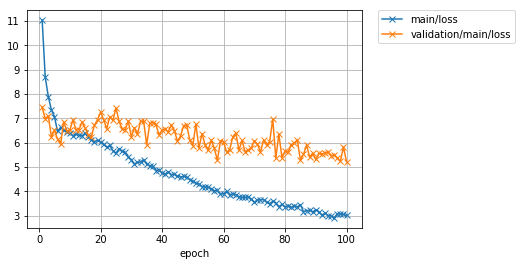

In [21]:
Image('mnist_back_image_result/loss.png')

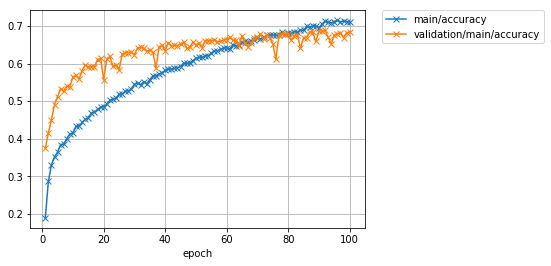

In [22]:
Image('mnist_back_image_result/accuracy.png')

In [0]:
from google.colab import files
files.download('mnist_back_image.npz')